**Dataseps://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv


In [ ]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [ ]:
#checking my tensorflow version
tf.__version__

'2.8.0'

In [ ]:
#Import the data and remove rows containing NAN values
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
df=df. iloc[::-1]
df.head()



,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [ ]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35


In [ ]:
#Data Preprocessing
df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [ ]:
df.shape

(2035, 8)

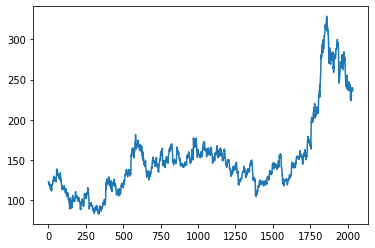

In [ ]:
df_high=df.reset_index()['High']
plt.plot(df_high)

In [ ]:
#Since LSTM are sensitive to the scale of the data, so we apply MinMax Scaler to transform our values between 0 and 1

scaler = MinMaxScaler(feature_range = (0,1))
df_high = scaler.fit_transform(np.array(df_high).reshape(-1,1))

In [ ]:
df_high.shape

(2035, 1)

In [ ]:
df_high

array([[0.16344786],
       [0.15938199],
       [0.15917869],
       ...,
       [0.6391543 ],
       [0.62614353],
       [0.62268754]])

In [ ]:
#Split the data into train and test split
training_size = int(len(df_high) * 0.75)
test_size = len(df_high) - training_size
train_data, test_data = df_high[0:training_size,:], df_high[training_size:len(df_high),:1]


In [ ]:
training_size,test_size

(1526, 509)

In [ ]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

    
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [ ]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


print(x_train.shape), print(y_train.shape)

(1425, 100, 1)
(1425,)


(None, None)

In [ ]:
print(x_test.shape), print(y_test.shape)

(408, 100, 1)
(408,)


(None, None)

In [ ]:
#Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 33s 531ms/step - loss: 0.0123 - val_loss: 0.0557
Epoch 2/100
23/23 [==============================] - 14s 604ms/step - loss: 0.0019 - val_loss: 0.0049
Epoch 3/100
23/23 [==============================] - 15s 651ms/step - loss: 9.3129e-04 - val_loss: 0.0033
Epoch 4/100
23/23 [==============================] - 18s 776ms/step - loss: 7.9956e-04 - val_loss: 0.0046
Epoch 5/100
23/23 [==============================] - 14s 594ms/step - loss: 7.9254e-04 - val_loss: 0.0045
Epoch 6/100
23/23 [==============================] - 13s 567ms/step - loss: 7.7343e-04 - val_loss: 0.0036
Epoch 7/100
23/23 [==============================] - 12s 498ms/step - loss: 7.0810e-04 - val_loss: 0.0045
Epoch 8/100
23/23 [==============================] - 8s 353ms/step - loss: 6.8340e-04 - val_loss: 0.0036
Epoch 9/100
23/23 [==============================] - 14s 616ms/step - loss: 6.4036e-04 - val_loss: 0.0059
Epoch 10/100
23/23 [==============================] - 1

In [84]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)


In [68]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [69]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

135.25613067921722

In [70]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

225.62041546984733

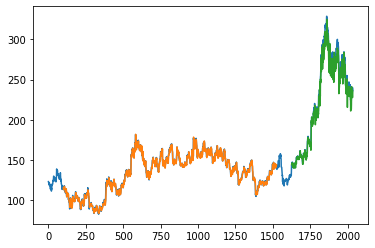

Green indicates the Predicted Data
Blue indicates the Complete Data
Orange indicates the Train Data


In [71]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_high)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_high) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print("Green indicates the Predicted Data")
print("Blue indicates the Complete Data")
print("Orange indicates the Train Data")

In [72]:
#Predict the next 28 days Stock Price
len(test_data), x_test.shape

(509, (408, 100, 1))

In [73]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [74]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output=[]
n_steps=100
nextNumberOfDays = 28
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.59457695]
101
1 day input [0.86013417 0.85464525 0.84448059 0.8072779  0.71843871 0.66192316
 0.67696686 0.67554381 0.67310429 0.68428542 0.68936776 0.70217524
 0.71803212 0.72941655 0.73144948 0.74486684 0.76926205 0.75991055
 0.74242732 0.73958122 0.74771295 0.75991055 0.7584875  0.76621264
 0.75462492 0.76316324 0.79670665 0.80585485 0.7889815  0.78003659
 0.73978451 0.73002643 0.73490547 0.74872942 0.75991055 0.75462492
 0.75401504 0.76174019 0.7737345  0.82008538 0.80585485 0.81154706
 0.77434438 0.78633869 0.79284407 0.78328929 0.77109169 0.74385038
 0.71193332 0.68733482 0.67818662 0.65257166 0.64301687 0.65643423
 0.67656028 0.67371417 0.65114861 0.65521447 0.66761537 0.67838992
 0.69993901 0.63122586 0.63508843 0.64098394 0.64545639 0.64118723
 0.63854442 0.63081927 0.62472047 0.6330555  0.64728603 0.6574507
 0.66761537 0.66720878 0.64159382 0.62776987 0.63651149 0.63630819
 0.62980281 0.62817646 0.63813783 0.65358813 0.63183574 0.57653995
 0.57816629 0.57613336 0.61943484 

In [75]:
day_new = np.arange(1,101)
day_pred = np.arange(101,129)

In [76]:
day_new.shape

(100,)

In [77]:
day_pred.shape

(28,)

In [78]:
df3 = df_high.tolist()
df3.extend(lst_output)

len(df_high)

2035

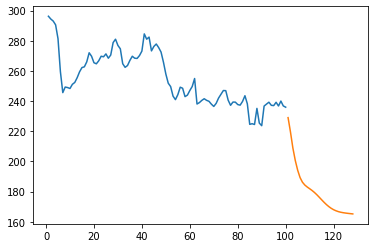

In [79]:
plt.plot(day_new, scaler.inverse_transform(df_high[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

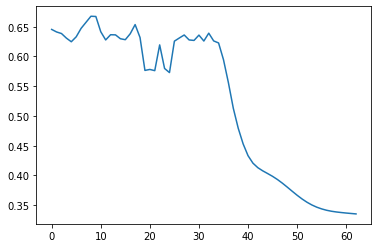

In [80]:
df3=df_high.tolist()
df3.extend(lst_output)
plt.plot(df3[2000:])

In [83]:
df3=scaler.inverse_transform(df3).tolist()

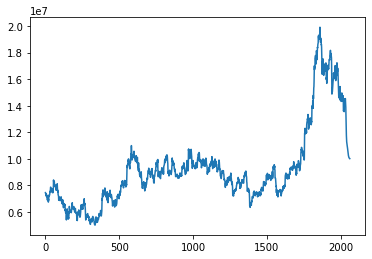

In [85]:
plt.plot(df3)